In [ ]:
#!/usr/bin/env python3
# train_and_evaluate.py

from pathlib import Path
import json
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    roc_curve,
    auc
)
import matplotlib.pyplot as plt

# ----------------- 하이퍼파라미터 ----------------------
DATA_ROOT     = Path("embbeding_data")    # 임베딩 데이터 폴더
AGG_METHOD    = "mean"                    # "mean" | "max" | "flatten"
BATCH         = 64                        # 배치 크기
EPOCHS        = 60                        # 에폭 수
LR            = 1e-4                      # 학습률
WEIGHT_DECAY  = 1e-4                      # AdamW 가중치 감쇠
HIDDEN_DIMS   = (1024, 256)               # 은닉층 크기
DROPOUT_P     = 0.5                       # 드롭아웃 비율
DEVICE        = "cuda:0" if torch.cuda.is_available() else "cpu"
SAVE_DIR      = Path("fusion_ckpt")       # 저장 디렉토리

# ---------- 유틸리티 ----------------------------------------------------
def load_split(split: str, model: str):
    base = DATA_ROOT / model / split
    emb  = np.load(base / "embeddings.npy")
    lbl  = np.load(base / "labels.npy").ravel()
    return emb, lbl

def reduce_stgcn(arr):
    if AGG_METHOD == "mean":
        return np.nanmean(arr, axis=1)
    if AGG_METHOD == "max":
        return np.nanmax(arr, axis=1)
    if AGG_METHOD == "flatten":
        return arr.reshape(arr.shape[0], -1)
    raise ValueError(f"AGG_METHOD={AGG_METHOD}")

# ---------- 데이터 로드 및 전처리 --------------------------------------
# train
ts_tr, y_tr = load_split("train", "timesformer")
st_tr, _    = load_split("train", "stgcnpp")
st_tr_flat  = reduce_stgcn(st_tr)
X_tr = np.concatenate([ts_tr, st_tr_flat], axis=1).astype(np.float32)
y_tr = y_tr.astype(np.int64)

# valid
ts_va, y_va = load_split("valid", "timesformer")
st_va, _    = load_split("valid", "stgcnpp")
st_va_flat  = reduce_stgcn(st_va)
X_va = np.concatenate([ts_va, st_va_flat], axis=1).astype(np.float32)
y_va = y_va.astype(np.int64)

# DataLoaders
dl_tr = DataLoader(
    TensorDataset(torch.from_numpy(X_tr), torch.from_numpy(y_tr)),
    batch_size=BATCH, shuffle=True
)
dl_va = DataLoader(
    TensorDataset(torch.from_numpy(X_va), torch.from_numpy(y_va)),
    batch_size=BATCH, shuffle=False
)

# ---------- 모델 정의 ----------------------------------------------------
class FusionMLP(nn.Module):
    def __init__(self, in_dim, n_cls, hidden, p_drop):
        super().__init__()
        layers, dims = [], [in_dim, *hidden]
        for d_in, d_out in zip(dims[:-1], dims[1:]):
            layers += [nn.Linear(d_in, d_out), nn.ReLU(), nn.Dropout(p_drop)]
        layers += [nn.Linear(dims[-1], n_cls)]
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

n_cls = int(max(y_tr.max(), y_va.max())) + 1
model = FusionMLP(in_dim=X_tr.shape[1], n_cls=n_cls,
                  hidden=HIDDEN_DIMS, p_drop=DROPOUT_P).to(DEVICE)
opt   = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
crit  = nn.CrossEntropyLoss()

# ---------- 학습 및 검증 ------------------------------------------------
train_losses, train_accs, val_losses, val_accs = [], [], [], []
best_acc, best_state = 0.0, None

for epoch in range(1, EPOCHS+1):
    # Train
    model.train()
    sum_loss, sum_correct, sum_total = 0.0, 0, 0
    for x, y in dl_tr:
        x, y = x.to(DEVICE), y.to(DEVICE)
        opt.zero_grad()
        out = model(x)
        loss = crit(out, y)
        loss.backward()
        opt.step()
        sum_loss    += loss.item() * y.size(0)
        sum_correct += (out.argmax(1) == y).sum().item()
        sum_total   += y.size(0)
    tr_loss = sum_loss / sum_total
    tr_acc  = sum_correct / sum_total

    # Validate
    model.eval()
    v_loss_sum, v_total = 0.0, 0
    preds, truths = [], []
    with torch.no_grad():
        for x, y in dl_va:
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            loss = crit(out, y)
            v_loss_sum += loss.item() * y.size(0)
            v_total    += y.size(0)
            preds.append(out.argmax(1).cpu().numpy())
            truths.append(y.cpu().numpy())
    val_loss = v_loss_sum / v_total
    val_pred = np.concatenate(preds)
    val_true = np.concatenate(truths)
    val_acc  = accuracy_score(val_true, val_pred)

    # 기록
    train_losses.append(tr_loss)
    train_accs.append(tr_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"[{epoch:02d}/{EPOCHS}] "
          f"tr_loss={tr_loss:.4f} tr_acc={tr_acc*100:.2f}%  "
          f"val_loss={val_loss:.4f} val_acc={val_acc*100:.2f}%")

    # 베스트 모델 저장
    if val_acc > best_acc:
        best_acc, best_state = val_acc, model.state_dict()

# 모델 저장
SAVE_DIR.mkdir(parents=True, exist_ok=True)
torch.save(best_state, SAVE_DIR / "fusion_mlp_best.pth")

# ---------- 최종 평가 및 메트릭 저장 ------------------------------------
model.load_state_dict(best_state)
model.eval()

# 예측 확률 수집
all_probs = []
all_preds = []
all_trues = []
with torch.no_grad():
    for x, y in dl_va:
        x = x.to(DEVICE)
        out = model(x)
        all_probs.extend(torch.softmax(out, dim=1)[:,1].cpu().numpy())
        all_preds.extend(out.argmax(1).cpu().numpy())
        all_trues.extend(y.numpy())

all_trues = np.array(all_trues)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

# 분류 리포트
clf_report = classification_report(all_trues, all_preds, digits=4, output_dict=True)
acc = accuracy_score(all_trues, all_preds)
cm  = confusion_matrix(all_trues, all_preds)

# ROC
fpr, tpr, _ = roc_curve(all_trues, all_probs)
roc_auc = auc(fpr, tpr)

# 메트릭 JSON 저장
metrics = {
    "accuracy": acc,
    "roc_auc": roc_auc,
    "confusion_matrix": cm.tolist(),
    "classification_report": clf_report
}
with open(SAVE_DIR / "metrics.json", "w", encoding="utf-8") as jf:
    json.dump(metrics, jf, indent=2)

# 분류 리포트 텍스트 저장
with open(SAVE_DIR / "classification_report.txt", "w", encoding="utf-8") as tf:
    tf.write(classification_report(all_trues, all_preds, digits=4))

# ROC 커브 저장
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('Validation ROC'); plt.legend()
plt.grid(True)
plt.savefig(SAVE_DIR / "roc_curve.png")
plt.close()

# 혼동 행렬 저장
plt.figure()
plt.matshow(cm, cmap='Blues')
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha='center', va='center')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.colorbar()
plt.savefig(SAVE_DIR / "confusion_matrix.png")
plt.close()

# 학습/검증 곡선 저장
epochs = list(range(1, EPOCHS+1))
plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses,   label='Valid Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss Curve'); plt.legend(); plt.grid(True)
plt.savefig(SAVE_DIR / "loss_curve.png")
plt.close()

plt.figure()
plt.plot(epochs, train_accs, label='Train Acc')
plt.plot(epochs, val_accs,   label='Valid Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy Curve'); plt.legend(); plt.grid(True)
plt.savefig(SAVE_DIR / "accuracy_curve.png")
plt.close()

print(f"✅ All metrics saved in {SAVE_DIR.resolve()}")


[Train 01/60] loss=0.6949
[Train 02/60] loss=0.6722
[Train 03/60] loss=0.6568
[Train 04/60] loss=0.6433
[Train 05/60] loss=0.6154
[Train 06/60] loss=0.6038
[Train 07/60] loss=0.5720
[Train 08/60] loss=0.5493
[Train 09/60] loss=0.5257
[Train 10/60] loss=0.4954
[Train 11/60] loss=0.4668
[Train 12/60] loss=0.4574
[Train 13/60] loss=0.4007
[Train 14/60] loss=0.3837
[Train 15/60] loss=0.3617
[Train 16/60] loss=0.3439
[Train 17/60] loss=0.3166
[Train 18/60] loss=0.3179
[Train 19/60] loss=0.2810
[Train 20/60] loss=0.2721
[Train 21/60] loss=0.2537
[Train 22/60] loss=0.2464
[Train 23/60] loss=0.2299
[Train 24/60] loss=0.2261
[Train 25/60] loss=0.1974
[Train 26/60] loss=0.1814
[Train 27/60] loss=0.1806
[Train 28/60] loss=0.1889
[Train 29/60] loss=0.1670
[Train 30/60] loss=0.1647
[Train 31/60] loss=0.1502
[Train 32/60] loss=0.1458
[Train 33/60] loss=0.1228
[Train 34/60] loss=0.1168
[Train 35/60] loss=0.1234
[Train 36/60] loss=0.1073
[Train 37/60] loss=0.1281
[Train 38/60] loss=0.1213
[Train 39/60

              precision    recall  f1-score   support

           0     0.8261    0.9500    0.8837        20
           1     0.9524    0.8333    0.8889        24

    accuracy                         0.8864        44
   macro avg     0.8892    0.8917    0.8863        44
weighted avg     0.8950    0.8864    0.8865        44

Valid Accuracy: 88.64%


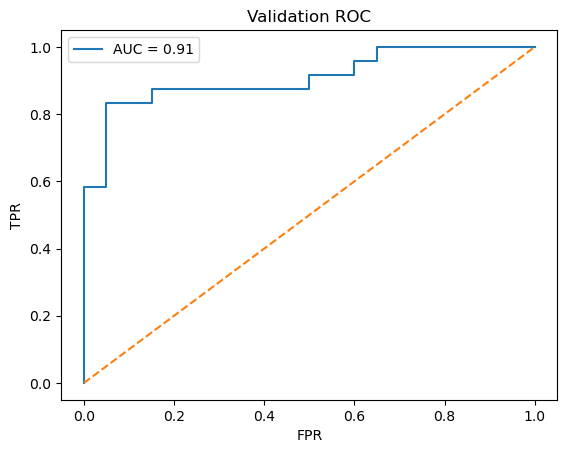

<Figure size 640x480 with 0 Axes>

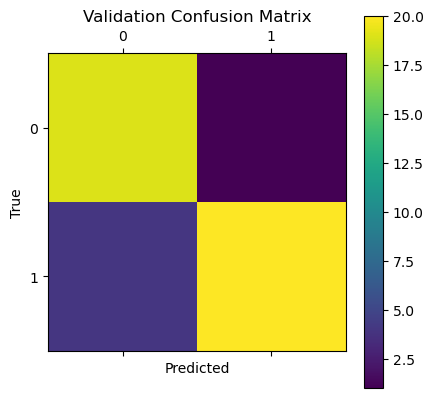

In [ ]:
# validate_fusion.py

from pathlib import Path
import numpy as np, torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# ----------------- 환경 설정 --------------------------------------------
DATA_ROOT = Path("embbeding_data")
AGG_METHOD = "mean"
BATCH      = 64
HIDDEN_DIMS= (1024, 256)
DROPOUT_P  = 0.5
DEVICE     = "cuda:0" if torch.cuda.is_available() else "cpu"
SAVE_DIR   = Path("fusion_ckpt")

# ---------- 데이터 로드 --------------------------------------------------
def load_split(split: str, model: str):
    base = DATA_ROOT / model / split
    emb  = np.load(base / "embeddings.npy")
    lbl  = np.load(base / "labels.npy").ravel()
    return emb, lbl

def reduce_stgcn(arr):
    if AGG_METHOD == "mean":
        return np.nanmean(arr, axis=1)
    if AGG_METHOD == "max":
        return np.nanmax(arr, axis=1)
    if AGG_METHOD == "flatten":
        return arr.reshape(arr.shape[0], -1)
    raise ValueError

# Timesformer & ST-GCN 임베딩 로드 (valid만)
ts_va, y_va = load_split("valid", "timesformer")
st_va, _    = load_split("valid", "stgcnpp")
st_va_flat  = reduce_stgcn(st_va)

# 특징 결합
X_va = np.concatenate([ts_va, st_va_flat], axis=1).astype(np.float32)
y_va = y_va.astype(np.int64)

ds_va = TensorDataset(torch.from_numpy(X_va), torch.from_numpy(y_va))
dl_va = DataLoader(ds_va, batch_size=BATCH, shuffle=False)

# ---------- 모델 정의 및 로드 --------------------------------------------
class FusionMLP(nn.Module):
    def __init__(self, in_dim, n_cls, hidden, p_drop):
        super().__init__()
        layers, dims = [], [in_dim, *hidden]
        for d_in, d_out in zip(dims[:-1], dims[1:]):
            layers += [nn.Linear(d_in, d_out), nn.ReLU(), nn.Dropout(p_drop)]
        layers += [nn.Linear(dims[-1], n_cls)]
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

in_dim = X_va.shape[1]
n_cls  = int(y_va.max()) + 1
model  = FusionMLP(in_dim, n_cls, HIDDEN_DIMS, DROPOUT_P).to(DEVICE)
state  = torch.load(SAVE_DIR / "fusion_mlp_best.pth", map_location=DEVICE)
model.load_state_dict(state)
model.eval()

# ---------- 평가 --------------------------------------------------------
y_true, y_pred, probs = [], [], []
with torch.no_grad():
    for x, y in dl_va:
        x = x.to(DEVICE)
        out = model(x)
        probs.extend(torch.softmax(out, dim=1)[:,1].cpu().numpy())
        y_true.extend(y.numpy())
        y_pred.extend(out.argmax(1).cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print(classification_report(y_true, y_pred, digits=4))
print(f"Valid Accuracy: {accuracy_score(y_true, y_pred)*100:.2f}%")

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, probs)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('Validation ROC'); plt.legend()
plt.savefig(SAVE_DIR / "validation_roc.png")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure()
plt.matshow(cm)
plt.title('Validation Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.colorbar()
plt.savefig(SAVE_DIR / "validation_cm.png")


              precision    recall  f1-score   support

           0     0.0833    1.0000    0.1538         1
           1     1.0000    0.7250    0.8406        40

    accuracy                         0.7317        41
   macro avg     0.5417    0.8625    0.4972        41
weighted avg     0.9776    0.7317    0.8238        41

Test Accuracy: 73.17%


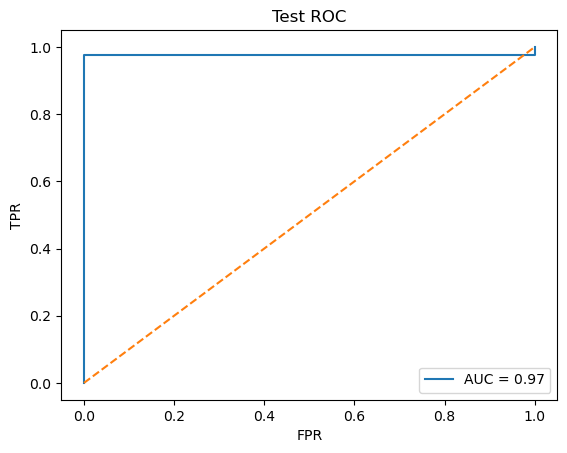

<Figure size 640x480 with 0 Axes>

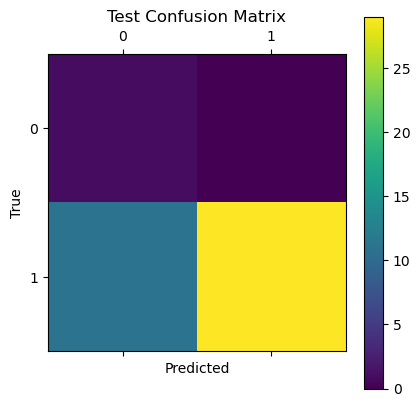

In [4]:
# test_fusion.py

from pathlib import Path
import numpy as np, torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# ----------------- 환경 설정 --------------------------------------------
DATA_ROOT = Path("embbeding_data")
AGG_METHOD = "mean"
BATCH      = 64
HIDDEN_DIMS= (1024, 256)
DROPOUT_P  = 0.5
DEVICE     = "cuda:0" if torch.cuda.is_available() else "cpu"
SAVE_DIR   = Path("fusion_ckpt")

# ---------- 데이터 로드 --------------------------------------------------
def load_split(split: str, model: str):
    base = DATA_ROOT / model / split
    emb  = np.load(base / "embeddings.npy")
    lbl  = np.load(base / "labels.npy").ravel()
    return emb, lbl

def reduce_stgcn(arr):
    if AGG_METHOD == "mean":
        return np.nanmean(arr, axis=1)
    if AGG_METHOD == "max":
        return np.nanmax(arr, axis=1)
    if AGG_METHOD == "flatten":
        return arr.reshape(arr.shape[0], -1)
    raise ValueError

# Timesformer & ST-GCN 임베딩 로드 (test)
ts_te, y_te = load_split("test", "timesformer")
st_te, _    = load_split("test", "stgcnpp")
st_te_flat  = reduce_stgcn(st_te)

# 특징 결합
X_te = np.concatenate([ts_te, st_te_flat], axis=1).astype(np.float32)
y_te = y_te.astype(np.int64)

ds_te = TensorDataset(torch.from_numpy(X_te), torch.from_numpy(y_te))
dl_te = DataLoader(ds_te, batch_size=BATCH, shuffle=False)

# ---------- 모델 정의 및 로드 --------------------------------------------
class FusionMLP(nn.Module):
    def __init__(self, in_dim, n_cls, hidden, p_drop):
        super().__init__()
        layers, dims = [], [in_dim, *hidden]
        for d_in, d_out in zip(dims[:-1], dims[1:]):
            layers += [nn.Linear(d_in, d_out), nn.ReLU(), nn.Dropout(p_drop)]
        layers += [nn.Linear(dims[-1], n_cls)]
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

in_dim = X_te.shape[1]
n_cls  = int(y_te.max()) + 1
model  = FusionMLP(in_dim, n_cls, HIDDEN_DIMS, DROPOUT_P).to(DEVICE)
state  = torch.load(SAVE_DIR / "fusion_mlp_best.pth", map_location=DEVICE)
model.load_state_dict(state)
model.eval()

# ---------- 평가 --------------------------------------------------------
y_true, y_pred, probs = [], [], []
with torch.no_grad():
    for x, y in dl_te:
        x = x.to(DEVICE)
        out = model(x)
        probs.extend(torch.softmax(out, dim=1)[:,1].cpu().numpy())
        y_true.extend(y.numpy())
        y_pred.extend(out.argmax(1).cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print(classification_report(y_true, y_pred, digits=4))
print(f"Test Accuracy: {accuracy_score(y_true, y_pred)*100:.2f}%")

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, probs)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('Test ROC'); plt.legend()
plt.savefig(SAVE_DIR / "test_roc.png")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure()
plt.matshow(cm)
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.colorbar()
plt.savefig(SAVE_DIR / "test_cm.png")
